In [1]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from tensorboardX import SummaryWriter

/opt/conda/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Constants definitions

In [2]:
PATH = "../datasets/yeast_v4"
data_path = Path(PATH)

In [11]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200
NAME = "Res_Net_34_Batch_Eq"
RESULTS = './results/'

## TensorBoard setup

In [9]:
if not os.path.isdir(RESULTS): os.makedirs(RESULTS)

In [12]:
writer = SummaryWriter(RESULTS+NAME)

In [13]:
stats_name = "yeast_v4_per_class.dict"
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs,save_name=stats_name)

working on: mfb1KO
working on: mfb1KO_mmr1KO
working on: mmr1KO
working on: WT


In [14]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs,balance=True)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [15]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_dict)

-0.006970908076958817
-0.003947202223064285
0.14443836282916744
-0.046832720460695205

 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmr1KO': 3}


In [16]:
x, y = next(iter(data.trn_dl))

In [17]:
print(y.size())

torch.Size([64])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


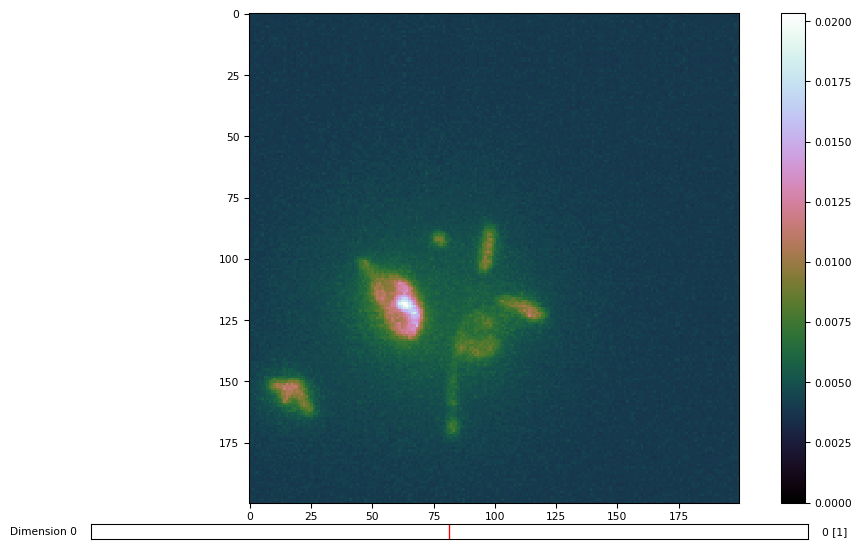

In [19]:
idx = 0
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx]).squeeze()[:,:,1]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

In [20]:
torch.cuda.is_available()

True

## ResNet_with_Batchnorm

In [21]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [22]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [23]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [24]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], NUM_CLASSES), data)

In [25]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
     

In [26]:
wd=1e-5

In [27]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

[0]:  1.0%                                               
[1]:  0.0%
[2]:  0.0%
[3]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      28.993287  13.44795   0.285714  
[0]:  0.0%                                                
[1]:  0.0%
[2]:  1.0%
[3]:  0.0%
    1      17.86311   7.469954   0.238095  
[0]:  1.0%                                                
[1]:  0.0%
[2]:  0.0%
[3]:  0.0%
    2      12.143485  2.159156   0.285714  
[0]:  0.0%                                                
[1]:  0.0%
[2]: 0.92%
[3]: 0.04167%
    3      8.721908   1.594473   0.228571  
[0]:  0.0%                                                
[1]:  0.0%
[2]:  0.0%
[3]:  1.0%
    4      7.752249   4.35291    0.228571  
[0]: 0.9333%                                              
[1]: 0.3462%
[2]:  0.0%
[3]: 0.04167%
    5      6.429612   1.840494   0.361905  
[0]: 0.2667%                                              
[1]:  0.0%
[2]:  0.8%
[3]: 0.08333%
    6      5.324543   1.381621   0.28

KeyboardInterrupt: 

In [18]:
# at very little overfitting we have 43% accuracy
%time learn.fit(1e-2, 8, wds=wd, cycle_len=4, use_clr=(20,8, 0.95, 0.85))

[0]: 56.67%                                               
[1]: 38.46%
[2]:  0.0%
[3]: 66.67%
epoch      trn_loss   val_loss   accuracy   
    0      1.055024   1.339168   0.447619  
[0]: 50.0%                                                
[1]:  0.0%
[2]:  4.0%
[3]: 83.33%
    1      1.065768   1.445546   0.352381  
[0]: 46.67%                                               
[1]: 50.0%
[2]: 20.0%
[3]: 45.83%
    2      1.057209   1.3018     0.409524  
[0]: 56.67%                                               
[1]: 26.92%
[2]:  8.0%
[3]: 75.0%
    3      1.054086   1.358573   0.47619   
[0]: 50.0%                                                
[1]: 69.23%
[2]: 16.0%
[3]: 45.83%
    4      1.056146   1.286598   0.47619   
[0]: 56.67%                                               
[1]: 50.0%
[2]:  8.0%
[3]: 54.17%
    5      1.050587   1.295403   0.47619   
[0]: 56.67%                                               
[1]: 38.46%
[2]: 16.0%
[3]: 62.5%
    6      1.037833   1.310056   0.485

[1.1465752544857206, 0.48571428912026543]

In [19]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

[0]: 56.67%                                               
[1]: 65.38%
[2]:  4.0%
[3]: 50.0%
epoch      trn_loss   val_loss   accuracy   
    0      0.780037   1.186984   0.47619   
[0]: 50.0%                                                 
[1]: 46.15%
[2]: 32.0%
[3]: 41.67%
    1      0.794156   1.109323   0.47619   
[0]: 56.67%                                                
[1]: 76.92%
[2]:  4.0%
[3]: 41.67%
    2      0.81692    1.154865   0.466667  
[0]: 63.33%                                                
[1]: 76.92%
[2]:  0.0%
[3]: 58.33%
    3      0.806442   1.360703   0.552381  
[0]: 50.0%                                                 
[1]: 80.77%
[2]:  8.0%
[3]: 41.67%
    4      0.800649   1.178      0.504762  
[0]: 36.67%                                                
[1]: 73.08%
[2]: 32.0%
[3]: 41.67%
    5      0.801978   1.161774   0.504762  
[0]: 63.33%                                                
[1]: 65.38%
[2]: 36.0%
[3]: 25.0%
    6      0.806577   1.17087

[0]: 76.67%                                                
[1]: 57.69%
[2]: 12.0%
[3]: 66.67%
    59     0.552887   1.022266   0.609524  
[0]: 66.67%                                                
[1]: 69.23%
[2]: 24.0%
[3]: 58.33%
    60     0.55179    1.045492   0.6       
[0]: 53.33%                                                
[1]: 84.62%
[2]: 32.0%
[3]: 45.83%
    61     0.537031   1.058643   0.571429  
[0]: 80.0%                                                 
[1]: 38.46%
[2]: 16.0%
[3]: 62.5%
    62     0.532487   0.927059   0.571429  
[0]: 76.67%                                                
[1]: 50.0%
[2]: 16.0%
[3]: 75.0%
    63     0.529166   0.967367   0.628571  
[0]: 53.33%                                                
[1]: 84.62%
[2]: 16.0%
[3]: 58.33%
    64     0.532486   1.107294   0.590476  
[0]: 83.33%                                                
[1]: 61.54%
[2]: 12.0%
[3]: 54.17%
    65     0.528958   1.115455   0.571429  
[0]: 83.33%                   

[0]: 60.0%                                                 
[1]: 65.38%
[2]: 36.0%
[3]: 62.5%
   177     0.317756   1.001564   0.647619  
[0]: 70.0%                                                 
[1]: 73.08%
[2]: 52.0%
[3]: 62.5%
   178     0.314129   0.88688    0.714286  
[0]: 80.0%                                                 
[1]: 57.69%
[2]: 56.0%
[3]: 58.33%
   179     0.309401   0.88032    0.714286  
[0]: 90.0%                                                 
[1]: 53.85%
[2]: 20.0%
[3]: 41.67%
   180     0.299495   1.295381   0.6       
[0]: 86.67%                                                
[1]: 53.85%
[2]: 32.0%
[3]: 54.17%
   181     0.292139   1.020642   0.657143  
[0]: 63.33%                                                
[1]: 65.38%
[2]: 56.0%
[3]: 58.33%
   182     0.285173   0.979775   0.666667  
[0]: 66.67%                                                
[1]: 30.77%
[2]: 40.0%
[3]: 83.33%
   183     0.28901    0.985579   0.695238  
[0]: 86.67%                  

[0]: 93.33%                                                
[1]: 50.0%
[2]:  8.0%
[3]: 87.5%
   295     0.159048   1.822573   0.609524  
[0]: 93.33%                                                
[1]: 42.31%
[2]: 20.0%
[3]: 83.33%
   296     0.180508   1.508666   0.638095  
[0]: 90.0%                                                 
[1]: 50.0%
[2]: 20.0%
[3]: 70.83%
   297     0.181927   1.54036    0.647619  
[0]: 83.33%                                                
[1]: 57.69%
[2]: 20.0%
[3]: 75.0%
   298     0.178952   1.275071   0.647619  
[0]: 90.0%                                                 
[1]: 53.85%
[2]: 16.0%
[3]: 79.17%
   299     0.177107   1.351166   0.647619  
[0]: 76.67%                                                
[1]: 34.62%
[2]: 28.0%
[3]: 75.0%
   300     0.178888   1.31283    0.609524  
[0]: 76.67%                                                
[1]: 61.54%
[2]: 32.0%
[3]: 54.17%
   301     0.174597   1.131279   0.647619  
[0]: 93.33%                     

[1.3262626977193923, 0.6476190481867109]

In [22]:
from sklearn.metrics import confusion_matrix
from resources.plots import *
import pickle
log_preds, y = learn.TTA()
preds = np.argmax(log_preds[1], axis=1)
cm = confusion_matrix(preds,y)
with open('results/confusion_matrix.320.array','wb') as file:
    pickle.dump(cm,file)
plot_confusion_matrix(cm, data.classes)

FileNotFoundError: [Errno 2] No such file or directory: 'results/confusion_matrix.320.array'

In [23]:
%time learn.fit(1e-1, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

[0]: 96.67%                                                
[1]: 57.69%
[2]:  4.0%
[3]: 66.67%
epoch      trn_loss   val_loss   accuracy   
    0      0.103954   2.287479   0.609524  
[0]: 86.67%                                               
[1]: 23.08%
[2]: 56.0%
[3]: 8.333%
    1      1.328399   4.90109    0.495238  
[0]: 100.0%                                               
[1]: 7.692%
[2]:  0.0%
[3]:  0.0%
    2      3.773315   17.552755  0.314286  
[0]: 3.333%                                               
[1]:  0.0%
[2]:  8.0%
[3]: 100.0%
    3      4.280842   1.950001   0.247619  
[0]: 6.667%                                               
[1]: 42.31%
[2]: 12.0%
[3]: 62.5%
    4      3.515952   1.582384   0.304762  
[0]: 80.0%                                                
[1]:  0.0%
[2]:  0.0%
[3]: 37.5%
    5      2.975313   1.795522   0.266667  
[0]: 96.67%                                               
[1]: 7.692%
[2]:  0.0%
[3]: 37.5%
    6      2.591449   1.356044   0.380

[0]: 76.67%                                                
[1]: 69.23%
[2]: 40.0%
[3]: 45.83%
   118     0.331535   0.855984   0.638095  
[0]: 93.33%                                                
[1]: 69.23%
[2]: 24.0%
[3]: 58.33%
   119     0.321577   0.991922   0.657143  
[0]: 93.33%                                                
[1]: 65.38%
[2]: 32.0%
[3]: 58.33%
   120     0.30918    0.88405    0.647619  
[0]: 86.67%                                                
[1]: 61.54%
[2]: 36.0%
[3]: 50.0%
   121     0.297735   0.976861   0.647619  
[0]: 86.67%                                                
[1]: 57.69%
[2]: 12.0%
[3]: 75.0%
   122     0.301211   1.330781   0.657143  
[0]: 70.0%                                                
[1]: 80.77%
[2]: 28.0%
[3]: 66.67%
   123     0.309846   1.160586   0.714286  
[0]: 66.67%                                                
[1]: 57.69%
[2]:  0.0%
[3]: 83.33%
   124     0.394338   1.881381   0.619048  
[0]: 73.33%                   

[0]: 83.33%                                                
[1]: 69.23%
[2]: 20.0%
[3]: 66.67%
   236     0.142249   1.072912   0.685714  
[0]: 80.0%                                                
[1]: 57.69%
[2]: 20.0%
[3]: 70.83%
   237     0.129553   1.059713   0.67619   
[0]: 86.67%                                               
[1]: 69.23%
[2]: 20.0%
[3]: 62.5%
   238     0.120123   1.097178   0.666667  
[0]: 83.33%                                                
[1]: 69.23%
[2]: 20.0%
[3]: 66.67%
   239     0.113818   1.041374   0.657143  
[0]: 76.67%                                                
[1]: 69.23%
[2]: 24.0%
[3]: 75.0%
   240     0.107547   0.999682   0.657143  
[0]: 83.33%                                                
[1]: 57.69%
[2]: 24.0%
[3]: 83.33%
   241     0.10673    1.189867   0.685714  
[0]: 80.0%                                                 
[1]: 65.38%
[2]: 28.0%
[3]: 83.33%
   242     0.125137   1.389289   0.714286  
[0]: 60.0%                     

KeyboardInterrupt: 

In [24]:
learn.save('Objective_A_ResNets_per_class')

In [ ]:
log_preds, y = learn.TTA()

In [ ]:
y.shape

In [ ]:
log_preds[0].shape

In [ ]:
preds = np.argmax(log_preds[1],axis=1)
probs = np.exp(log_preds[:,1])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)